# Small Cardamom Price Forecasting — Long-Horizon Enriched Model

This notebook predicts cardamom prices **7, 14, and 30 days ahead** using external data.  
At these horizons, lag prices lose predictive power and fundamentals (weather, macro, demand cycles) become the real signal.

### Why Long-Horizon?
A next-day model just learns "tomorrow ≈ today" (R²=0.98 but useless for planning).  
Traders, farmers, and exporters need **1-4 week forecasts** to make decisions about:
- When to sell harvested cardamom
- When to buy for export contracts
- Inventory and storage decisions

### External Data Sources
| Source | Signal | Granularity |
|--------|--------|-------------|
| Open-Meteo | Idukki rainfall, temperature, humidity | Daily |
| Open-Meteo | Guatemala (Alta Verapaz) rainfall & temp | Daily |
| NOAA | El Niño/La Niña (ONI index) | Monthly |
| Yahoo Finance | USD/INR, Crude Oil, Gold, Nifty 50 | Daily |
| Custom | Festival/wedding/harvest calendar | Daily |

## 1. Load & Merge All Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['figure.dpi'] = 100

# --- Load cardamom auction data ---
df = pd.read_html('Small Cardamom Auction Prices.xls', header=0)[0]
df = df[df.iloc[:, 0] != 'Date of Auction'].reset_index(drop=True)
df.columns = ['Date', 'Auctioneer', 'Lots', 'Qty_Arrived_Kg', 'Qty_Sold_Kg', 'MaxPrice', 'AvgPrice']
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=False)
for col in ['Lots', 'Qty_Arrived_Kg', 'Qty_Sold_Kg', 'MaxPrice', 'AvgPrice']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=['Date']).reset_index(drop=True)

# Aggregate to daily
daily = df.groupby('Date').agg(
    Total_Lots=('Lots', 'sum'),
    Total_Arrived=('Qty_Arrived_Kg', 'sum'),
    Total_Sold=('Qty_Sold_Kg', 'sum'),
    MaxPrice=('MaxPrice', 'max'),
    AvgPrice=('AvgPrice', lambda x: np.average(x, weights=df.loc[x.index, 'Qty_Sold_Kg'].clip(lower=1))),
    Num_Auctions=('Auctioneer', 'nunique')
).reset_index()
daily = daily.sort_values('Date').reset_index(drop=True)
daily = daily[daily['AvgPrice'] > 0].reset_index(drop=True)

# --- Load external data ---
def load_yfinance_csv(path, value_col_name):
    raw = pd.read_csv(path, header=None, skiprows=3)
    raw.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
    raw['Date'] = pd.to_datetime(raw['Date'])
    raw = raw[['Date', 'Close']].rename(columns={'Close': value_col_name})
    raw[value_col_name] = pd.to_numeric(raw[value_col_name], errors='coerce')
    return raw.dropna()

weather = pd.read_csv('external_idukki_weather.csv', parse_dates=['Date'])
gt_weather = pd.read_csv('external_guatemala_weather.csv', parse_dates=['Date'])
usdinr = load_yfinance_csv('external_usdinr.csv', 'USDINR')
oil = load_yfinance_csv('external_crude_oil.csv', 'CrudeOil_USD')
gold = load_yfinance_csv('external_gold.csv', 'Gold_USD')
nifty = load_yfinance_csv('external_nifty50.csv', 'Nifty50')
festivals = pd.read_csv('external_festival_calendar.csv', parse_dates=['Date'])

oni_raw = pd.read_csv('external_enso_oni.csv')
season_to_month = {'DJF':1,'JFM':2,'FMA':3,'MAM':4,'AMJ':5,'MJJ':6,'JJA':7,'JAS':8,'ASO':9,'SON':10,'OND':11,'NDJ':12}
oni_raw['month'] = oni_raw['SEAS'].map(season_to_month)
oni_raw['Date'] = pd.to_datetime(oni_raw['YR'].astype(str) + '-' + oni_raw['month'].astype(str) + '-15')
oni = oni_raw[['Date', 'ANOM']].rename(columns={'ANOM': 'ENSO_ONI'})
oni = oni.set_index('Date').resample('D').ffill().reset_index()

# --- Merge ---
merged = daily.copy()
merged = merged.merge(weather, on='Date', how='left')
merged = merged.merge(gt_weather, on='Date', how='left')
for ext_df, name in [(usdinr,'USDINR'),(oil,'CrudeOil_USD'),(gold,'Gold_USD'),(nifty,'Nifty50')]:
    ext_df = ext_df.sort_values('Date').drop_duplicates(subset='Date')
    merged = merged.merge(ext_df, on='Date', how='left')
    merged[name] = merged[name].ffill()
merged = merged.merge(festivals, on='Date', how='left')
for col in ['wedding_season','harvest_season','peak_harvest','pre_eid_period','pre_diwali_period','pre_onam_period','xmas_newyear']:
    merged[col] = merged[col].fillna(0).astype(int)
merged = merged.merge(oni, on='Date', how='left')
merged['ENSO_ONI'] = merged['ENSO_ONI'].ffill()
merged = merged.ffill().bfill().dropna().reset_index(drop=True)

print(f'Merged dataset: {merged.shape[0]} rows, {merged.shape[1]} columns')
print(f'Date range: {merged["Date"].min().date()} to {merged["Date"].max().date()}')

Merged dataset: 3028 rows, 28 columns
Date range: 2014-11-07 to 2026-02-06


## 2. Weekly Resampling

Auctions don't happen every day (weekends, holidays). Resampling to **weekly frequency** gives us:
- Smoother, more predictable target
- Better alignment with weather (cumulative rainfall matters, not daily spikes)
- More natural horizon: predicting 1/2/4 weeks ahead

In [2]:
# Resample to weekly — use last auction day of each week
merged_idx = merged.set_index('Date')

weekly = pd.DataFrame()
weekly['AvgPrice'] = merged_idx['AvgPrice'].resample('W-FRI').mean()
weekly['MaxPrice'] = merged_idx['MaxPrice'].resample('W-FRI').max()
weekly['Total_Sold'] = merged_idx['Total_Sold'].resample('W-FRI').sum()
weekly['Total_Arrived'] = merged_idx['Total_Arrived'].resample('W-FRI').sum()
weekly['Num_Auctions'] = merged_idx['Num_Auctions'].resample('W-FRI').sum()

# Weather: weekly aggregates
weekly['rain_mm_week'] = merged_idx['rain_mm'].resample('W-FRI').sum()
weekly['rain_days'] = (merged_idx['rain_mm'] > 1).resample('W-FRI').sum()
weekly['temp_max_avg'] = merged_idx['temp_max_c'].resample('W-FRI').mean()
weekly['temp_min_avg'] = merged_idx['temp_min_c'].resample('W-FRI').mean()
weekly['humidity_avg'] = merged_idx['humidity_pct'].resample('W-FRI').mean()

# Guatemala weather
weekly['gt_rain_mm_week'] = merged_idx['gt_rain_mm'].resample('W-FRI').sum()
weekly['gt_temp_max_avg'] = merged_idx['gt_temp_max_c'].resample('W-FRI').mean()

# Financial: end-of-week values
weekly['USDINR'] = merged_idx['USDINR'].resample('W-FRI').last()
weekly['CrudeOil_USD'] = merged_idx['CrudeOil_USD'].resample('W-FRI').last()
weekly['Gold_USD'] = merged_idx['Gold_USD'].resample('W-FRI').last()
weekly['Nifty50'] = merged_idx['Nifty50'].resample('W-FRI').last()

# ENSO
weekly['ENSO_ONI'] = merged_idx['ENSO_ONI'].resample('W-FRI').last()

# Festivals: any day in the week flagged?
for col in ['wedding_season','harvest_season','peak_harvest','pre_eid_period','pre_diwali_period','pre_onam_period','xmas_newyear']:
    weekly[col] = merged_idx[col].resample('W-FRI').max()

weekly = weekly.dropna().reset_index()
weekly.rename(columns={'Date': 'Week'}, inplace=True)

print(f'Weekly dataset: {len(weekly)} weeks')
print(f'Period: {weekly["Week"].min().date()} to {weekly["Week"].max().date()}')
weekly.head()

Weekly dataset: 546 weeks
Period: 2014-11-07 to 2026-02-06


,Week,AvgPrice,MaxPrice,Total_Sold,Total_Arrived,Num_Auctions,rain_mm_week,rain_days,temp_max_avg,temp_min_avg,...,Gold_USD,Nifty50,ENSO_ONI,wedding_season,harvest_season,peak_harvest,pre_eid_period,pre_diwali_period,pre_onam_period,xmas_newyear
0,2014-11-07,765.730000,958.0,109076.0,109975.0,1,0.9,0,27.200000,17.200000,...,1169.599976,8337.000000,0.54,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,2015-01-16,861.930000,1130.0,76699.0,76699.0,1,0.1,0,26.200000,13.500000,...,1234.400024,8277.549805,0.77,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2015-05-01,706.624575,928.0,30755.0,31117.0,2,5.8,1,29.000000,21.100000,...,1174.500000,8277.549805,0.81,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-05-08,678.488533,990.0,422784.0,435189.0,12,66.8,6,27.883333,20.666667,...,1189.099976,8191.500000,0.81,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-05-15,656.680237,939.0,481189.0,486868.0,12,74.1,6,26.316667,20.550000,...,1225.500000,8262.349609,1.02,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. Define Forecast Horizons & Targets

We create three separate prediction targets:
- **1-week ahead**: Price next week
- **2-week ahead**: Price in 2 weeks
- **4-week ahead**: Price in 4 weeks (≈1 month)

In [3]:
# Create forward-looking targets
for h in [1, 2, 4]:
    weekly[f'target_{h}w'] = weekly['AvgPrice'].shift(-h)
    # Also useful: price CHANGE (harder but more useful than level)
    weekly[f'target_{h}w_change'] = weekly['AvgPrice'].shift(-h) - weekly['AvgPrice']
    weekly[f'target_{h}w_pct'] = (weekly['AvgPrice'].shift(-h) / weekly['AvgPrice'] - 1) * 100

print('Target summary (price change %):')
for h in [1, 2, 4]:
    col = f'target_{h}w_pct'
    vals = weekly[col].dropna()
    print(f'  {h}-week: mean={vals.mean():.2f}%, std={vals.std():.2f}%, '
          f'min={vals.min():.1f}%, max={vals.max():.1f}%')

Target summary (price change %):
  1-week: mean=0.37%, std=5.66%, min=-27.0%, max=31.1%
  2-week: mean=0.77%, std=8.51%, min=-33.8%, max=35.8%
  4-week: mean=1.72%, std=13.03%, min=-47.5%, max=58.1%


## 4. Feature Engineering

All features use **only past data** (no lookahead). We focus on:
- Recent price trends & volatility
- Cumulative weather patterns (supply signal)
- Macro/financial regime
- Demand calendar

In [4]:
feat = weekly.copy()

# === PRICE FEATURES ===
# Lag prices (in weeks)
for lag in [1, 2, 3, 4, 6, 8, 12]:
    feat[f'price_lag_{lag}w'] = feat['AvgPrice'].shift(lag)

# Rolling stats
for w in [4, 8, 12, 26]:
    feat[f'price_ma_{w}w'] = feat['AvgPrice'].shift(1).rolling(w).mean()
    feat[f'price_std_{w}w'] = feat['AvgPrice'].shift(1).rolling(w).std()

# Price momentum
feat['price_mom_4w'] = feat['AvgPrice'].shift(1) - feat['AvgPrice'].shift(5)
feat['price_mom_8w'] = feat['AvgPrice'].shift(1) - feat['AvgPrice'].shift(9)
feat['price_mom_12w'] = feat['AvgPrice'].shift(1) - feat['AvgPrice'].shift(13)
feat['price_pct_4w'] = feat['AvgPrice'].shift(1).pct_change(4) * 100
feat['price_pct_8w'] = feat['AvgPrice'].shift(1).pct_change(8) * 100

# Price relative to moving averages (mean reversion signal)
feat['price_vs_ma12'] = feat['AvgPrice'].shift(1) / feat[f'price_ma_12w'].clip(lower=1) - 1
feat['price_vs_ma26'] = feat['AvgPrice'].shift(1) / feat[f'price_ma_26w'].clip(lower=1) - 1

# Max/Avg price spread (market premium)
feat['max_avg_spread'] = (feat['MaxPrice'].shift(1) / feat['AvgPrice'].shift(1).clip(lower=1)) - 1

# === VOLUME FEATURES ===
feat['sold_ma_4w'] = feat['Total_Sold'].shift(1).rolling(4).mean()
feat['sold_ma_8w'] = feat['Total_Sold'].shift(1).rolling(8).mean()
feat['arrived_ma_4w'] = feat['Total_Arrived'].shift(1).rolling(4).mean()
feat['sell_through_4w'] = (feat['Total_Sold'].shift(1).rolling(4).sum() / 
                           feat['Total_Arrived'].shift(1).rolling(4).sum().clip(lower=1))

# === WEATHER FEATURES (cumulative — the real supply driver) ===
# Idukki: cumulative rain over past N weeks
for w in [4, 8, 13, 26]:
    feat[f'idukki_rain_{w}w'] = feat['rain_mm_week'].shift(1).rolling(w).sum()
    feat[f'idukki_temp_{w}w'] = feat['temp_max_avg'].shift(1).rolling(w).mean()

feat['idukki_rain_days_4w'] = feat['rain_days'].shift(1).rolling(4).sum()
feat['idukki_humidity_4w'] = feat['humidity_avg'].shift(1).rolling(4).mean()
feat['idukki_humidity_12w'] = feat['humidity_avg'].shift(1).rolling(12).mean()

# Rain anomaly: current vs same-period historical average
feat['week_num'] = feat['Week'].dt.isocalendar().week.astype(int)
weekly_rain_avg = feat.groupby('week_num')['rain_mm_week'].transform('mean')
feat['rain_anomaly'] = feat['rain_mm_week'].shift(1) - weekly_rain_avg.shift(1)

# Guatemala: cumulative rain (competing supply signal, lagged further)
for w in [4, 8, 13, 26]:
    feat[f'guatemala_rain_{w}w'] = feat['gt_rain_mm_week'].shift(1).rolling(w).sum()
feat['guatemala_temp_12w'] = feat['gt_temp_max_avg'].shift(1).rolling(12).mean()

# === ENSO ===
feat['enso'] = feat['ENSO_ONI'].shift(1)
feat['enso_el_nino'] = (feat['enso'] > 0.5).astype(int)
feat['enso_la_nina'] = (feat['enso'] < -0.5).astype(int)

# === FINANCIAL FEATURES ===
feat['usdinr'] = feat['USDINR'].shift(1)
feat['usdinr_change_4w'] = feat['USDINR'].shift(1) - feat['USDINR'].shift(5)
feat['usdinr_change_12w'] = feat['USDINR'].shift(1) - feat['USDINR'].shift(13)
feat['usdinr_ma_12w'] = feat['USDINR'].shift(1).rolling(12).mean()

feat['oil'] = feat['CrudeOil_USD'].shift(1)
feat['oil_change_4w'] = feat['CrudeOil_USD'].shift(1) - feat['CrudeOil_USD'].shift(5)
feat['oil_change_12w'] = feat['CrudeOil_USD'].shift(1) - feat['CrudeOil_USD'].shift(13)

feat['gold'] = feat['Gold_USD'].shift(1)
feat['gold_change_4w'] = feat['Gold_USD'].shift(1) - feat['Gold_USD'].shift(5)

feat['nifty'] = feat['Nifty50'].shift(1)
feat['nifty_change_4w'] = feat['Nifty50'].shift(1) - feat['Nifty50'].shift(5)

# === CALENDAR / DEMAND FEATURES ===
feat['month'] = feat['Week'].dt.month
feat['month_sin'] = np.sin(2 * np.pi * feat['month'] / 12)
feat['month_cos'] = np.cos(2 * np.pi * feat['month'] / 12)
feat['quarter'] = feat['Week'].dt.quarter

# Festival features are already in the dataframe
# wedding_season, harvest_season, peak_harvest, pre_eid_period, etc.

# === Clean up ===
feat = feat.dropna(subset=[c for c in feat.columns if c.startswith('price_lag')]).reset_index(drop=True)

print(f'Feature dataset: {feat.shape[0]} rows, {feat.shape[1]} columns')
print(f'Period: {feat["Week"].min().date()} to {feat["Week"].max().date()}')

Feature dataset: 534 rows, 97 columns
Period: 2015-07-10 to 2026-02-06


In [5]:
# Define feature groups
exclude_cols = ['Week', 'AvgPrice', 'MaxPrice', 'Total_Sold', 'Total_Arrived', 'Num_Auctions',
                'rain_mm_week', 'rain_days', 'temp_max_avg', 'temp_min_avg', 'humidity_avg',
                'gt_rain_mm_week', 'gt_temp_max_avg',
                'USDINR', 'CrudeOil_USD', 'Gold_USD', 'Nifty50', 'ENSO_ONI', 'week_num',
                'target_1w', 'target_2w', 'target_4w',
                'target_1w_change', 'target_2w_change', 'target_4w_change',
                'target_1w_pct', 'target_2w_pct', 'target_4w_pct']

all_features = [c for c in feat.columns if c not in exclude_cols]

# Baseline: only price/volume features + calendar
baseline_features = [c for c in all_features if any(c.startswith(p) for p in
    ['price_', 'sold_', 'arrived_', 'sell_through', 'max_avg_spread',
     'month', 'quarter'])]

# External-only features
external_features = [c for c in all_features if c not in baseline_features]

print(f'All features: {len(all_features)}')
print(f'Baseline (price/volume/calendar): {len(baseline_features)}')
print(f'External (weather/macro/demand): {len(external_features)}')
print(f'\nExternal features:')
for f in sorted(external_features):
    print(f'  {f}')

All features: 69
Baseline (price/volume/calendar): 31
External (weather/macro/demand): 38

External features:
  enso
  enso_el_nino
  enso_la_nina
  gold
  gold_change_4w
  guatemala_rain_13w
  guatemala_rain_26w
  guatemala_rain_4w
  guatemala_rain_8w
  guatemala_temp_12w
  harvest_season
  idukki_humidity_12w
  idukki_humidity_4w
  idukki_rain_13w
  idukki_rain_26w
  idukki_rain_4w
  idukki_rain_8w
  idukki_rain_days_4w
  idukki_temp_13w
  idukki_temp_26w
  idukki_temp_4w
  idukki_temp_8w
  nifty
  nifty_change_4w
  oil
  oil_change_12w
  oil_change_4w
  peak_harvest
  pre_diwali_period
  pre_eid_period
  pre_onam_period
  rain_anomaly
  usdinr
  usdinr_change_12w
  usdinr_change_4w
  usdinr_ma_12w
  wedding_season
  xmas_newyear


## 5. Model Training — Baseline vs Enriched at Each Horizon

In [6]:
# Temporal split: 80% train, 20% test
split_idx = int(len(feat) * 0.8)

horizons = [1, 2, 4]
horizon_labels = {1: '1-Week', 2: '2-Week', 4: '4-Week'}

all_results = []
all_preds = {}

for horizon in horizons:
    target_col = f'target_{horizon}w'
    
    # Drop rows without target
    valid = feat.dropna(subset=[target_col]).reset_index(drop=True)
    si = int(len(valid) * 0.8)
    
    y_train = valid[target_col].iloc[:si]
    y_test = valid[target_col].iloc[si:]
    weeks_test = valid['Week'].iloc[si:]
    
    print(f'\n{"="*60}')
    print(f'  HORIZON: {horizon_labels[horizon]} Ahead')
    print(f'  Train: {si} weeks | Test: {len(valid)-si} weeks')
    print(f'  Test period: {weeks_test.iloc[0].date()} to {weeks_test.iloc[-1].date()}')
    print(f'{"="*60}')
    
    for feat_name, feat_cols in [('Baseline', baseline_features), ('Enriched', all_features)]:
        # Drop any feature cols with NaN in this subset
        valid_feat_cols = [c for c in feat_cols if c in valid.columns]
        X_train = valid[valid_feat_cols].iloc[:si]
        X_test = valid[valid_feat_cols].iloc[si:]
        
        # Drop cols that are all NaN
        good_cols = X_train.columns[X_train.notna().any()]
        X_train = X_train[good_cols].fillna(0)
        X_test = X_test[good_cols].fillna(0)
        
        models = {
            'Ridge': Ridge(alpha=10.0),
            'Random Forest': RandomForestRegressor(n_estimators=300, max_depth=10,
                                                   min_samples_leaf=5, random_state=42, n_jobs=-1),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=300, max_depth=5,
                                                           learning_rate=0.03, subsample=0.8,
                                                           min_samples_leaf=5, random_state=42)
        }
        
        print(f'\n  --- {feat_name} ({len(good_cols)} features) ---')
        for model_name, model in models.items():
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            
            mae = mean_absolute_error(y_test, pred)
            rmse = np.sqrt(mean_squared_error(y_test, pred))
            mape = mean_absolute_percentage_error(y_test, pred) * 100
            r2 = r2_score(y_test, pred)
            
            all_results.append({
                'Horizon': horizon_labels[horizon],
                'Features': feat_name,
                'Model': model_name,
                'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R²': r2
            })
            
            key = f'{horizon_labels[horizon]}_{feat_name}_{model_name}'
            all_preds[key] = {'pred': pred, 'actual': y_test.values, 'weeks': weeks_test.values,
                             'model': model, 'features': list(good_cols)}
            
            print(f'    {model_name:20s} | MAE: {mae:7.1f} | RMSE: {rmse:7.1f} | MAPE: {mape:5.2f}% | R²: {r2:.4f}')

results_df = pd.DataFrame(all_results)
print('\n\n')
results_df


  HORIZON: 1-Week Ahead
  Train: 426 weeks | Test: 107 weeks
  Test period: 2024-01-19 to 2026-01-30



  --- Baseline (31 features) ---
    Ridge                | MAE:   125.5 | RMSE:   157.0 | MAPE:  5.29% | R²: 0.8469


    Random Forest        | MAE:   163.9 | RMSE:   196.0 | MAPE:  6.90% | R²: 0.7613


    Gradient Boosting    | MAE:   209.9 | RMSE:   249.4 | MAPE:  8.80% | R²: 0.6135

  --- Enriched (69 features) ---
    Ridge                | MAE:   323.8 | RMSE:   400.9 | MAPE: 13.09% | R²: 0.0015


    Random Forest        | MAE:   176.1 | RMSE:   214.2 | MAPE:  7.45% | R²: 0.7149


    Gradient Boosting    | MAE:   173.5 | RMSE:   236.8 | MAPE:  6.97% | R²: 0.6515

  HORIZON: 2-Week Ahead
  Train: 425 weeks | Test: 107 weeks
  Test period: 2024-01-12 to 2026-01-23

  --- Baseline (31 features) ---
    Ridge                | MAE:   162.7 | RMSE:   199.4 | MAPE:  6.87% | R²: 0.7529


    Random Forest        | MAE:   295.8 | RMSE:   345.1 | MAPE: 12.27% | R²: 0.2600


    Gradient Boosting    | MAE:   356.0 | RMSE:   410.5 | MAPE: 14.61% | R²: -0.0467

  --- Enriched (69 features) ---
    Ridge                | MAE:   490.1 | RMSE:   594.0 | MAPE: 19.76% | R²: -1.1922


    Random Forest        | MAE:   291.9 | RMSE:   343.9 | MAPE: 12.37% | R²: 0.2653


    Gradient Boosting    | MAE:   200.9 | RMSE:   239.8 | MAPE:  8.54% | R²: 0.6428

  HORIZON: 4-Week Ahead
  Train: 424 weeks | Test: 106 weeks
  Test period: 2024-01-05 to 2026-01-09

  --- Baseline (31 features) ---
    Ridge                | MAE:   224.7 | RMSE:   271.2 | MAPE:  9.48% | R²: 0.5315


    Random Forest        | MAE:   551.5 | RMSE:   629.0 | MAPE: 22.76% | R²: -1.5195


    Gradient Boosting    | MAE:   555.3 | RMSE:   642.5 | MAPE: 22.76% | R²: -1.6283

  --- Enriched (69 features) ---
    Ridge                | MAE:   574.4 | RMSE:   680.5 | MAPE: 23.15% | R²: -1.9485


    Random Forest        | MAE:   449.8 | RMSE:   512.4 | MAPE: 18.71% | R²: -0.6717


    Gradient Boosting    | MAE:   523.5 | RMSE:   592.4 | MAPE: 21.57% | R²: -1.2349





,Horizon,Features,Model,MAE,RMSE,MAPE,R²
0,1-Week,Baseline,Ridge,125.483709,156.999017,5.293868,0.846857
1,1-Week,Baseline,Random Forest,163.887830,196.024426,6.897225,0.761260
2,1-Week,Baseline,Gradient Boosting,209.940051,249.416817,8.795755,0.613495
3,1-Week,Enriched,Ridge,323.807593,400.881658,13.092003,0.001527
4,1-Week,Enriched,Random Forest,176.099936,214.221118,7.450476,0.714879
5,1-Week,Enriched,Gradient Boosting,173.467459,236.849040,6.965542,0.651464
6,2-Week,Baseline,Ridge,162.671531,199.411891,6.870192,0.752938
7,2-Week,Baseline,Random Forest,295.803719,345.126133,12.273580,0.259952
8,2-Week,Baseline,Gradient Boosting,355.994706,410.455919,14.612360,-0.046736
9,2-Week,Enriched,Ridge,490.067496,593.995598,19.761051,-1.192151


## 6. Baseline vs Enriched Comparison

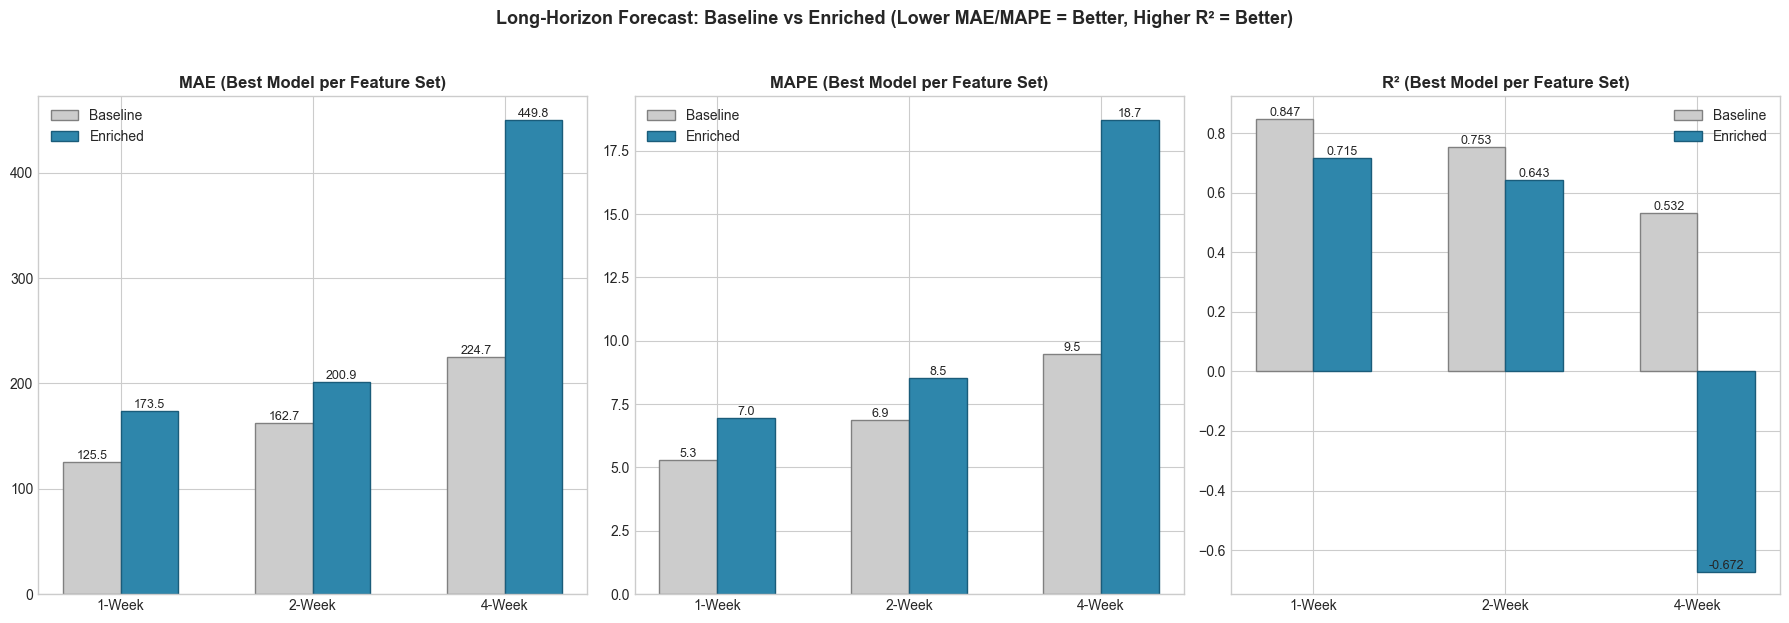

In [7]:
# Pivot for comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, metric, lower_better in zip(axes, ['MAE', 'MAPE', 'R²'], [True, True, False]):
    for i, horizon in enumerate(horizon_labels.values()):
        subset = results_df[results_df['Horizon'] == horizon]
        
        # Get best model per feature set
        if lower_better:
            baseline_best = subset[subset['Features']=='Baseline'][metric].min()
            enriched_best = subset[subset['Features']=='Enriched'][metric].min()
        else:
            baseline_best = subset[subset['Features']=='Baseline'][metric].max()
            enriched_best = subset[subset['Features']=='Enriched'][metric].max()
        
        x = i
        w = 0.3
        ax.bar(x - w/2, baseline_best, w, color='#cccccc', edgecolor='gray',
               label='Baseline' if i == 0 else '')
        ax.bar(x + w/2, enriched_best, w, color='#2E86AB', edgecolor='#1a5c7a',
               label='Enriched' if i == 0 else '')
        
        # Value labels
        fmt = '.1f' if metric != 'R²' else '.3f'
        ax.text(x - w/2, baseline_best, f'{baseline_best:{fmt}}', ha='center', va='bottom', fontsize=9)
        ax.text(x + w/2, enriched_best, f'{enriched_best:{fmt}}', ha='center', va='bottom', fontsize=9)
    
    ax.set_xticks(range(len(horizon_labels)))
    ax.set_xticklabels(horizon_labels.values())
    ax.set_title(f'{metric} (Best Model per Feature Set)', fontweight='bold', fontsize=12)
    ax.legend()

plt.suptitle('Long-Horizon Forecast: Baseline vs Enriched (Lower MAE/MAPE = Better, Higher R² = Better)',
             fontsize=13, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

In [8]:
# Improvement table: how much did external data help?
print('Improvement from External Data (best model at each horizon):\n')
print(f'{"Horizon":<12} {"Baseline MAE":>14} {"Enriched MAE":>14} {"Improvement":>14} {"Baseline R²":>12} {"Enriched R²":>12}')
print('-' * 82)

for horizon in horizon_labels.values():
    subset = results_df[results_df['Horizon'] == horizon]
    b_mae = subset[subset['Features']=='Baseline']['MAE'].min()
    e_mae = subset[subset['Features']=='Enriched']['MAE'].min()
    b_r2 = subset[subset['Features']=='Baseline']['R²'].max()
    e_r2 = subset[subset['Features']=='Enriched']['R²'].max()
    improvement = (b_mae - e_mae) / b_mae * 100
    print(f'{horizon:<12} {b_mae:>14.1f} {e_mae:>14.1f} {improvement:>13.1f}% {b_r2:>12.4f} {e_r2:>12.4f}')

Improvement from External Data (best model at each horizon):

Horizon        Baseline MAE   Enriched MAE    Improvement  Baseline R²  Enriched R²
----------------------------------------------------------------------------------
1-Week                125.5          173.5         -38.2%       0.8469       0.7149
2-Week                162.7          200.9         -23.5%       0.7529       0.6428
4-Week                224.7          449.8        -100.2%       0.5315      -0.6717


## 7. Best Model Deep-Dive

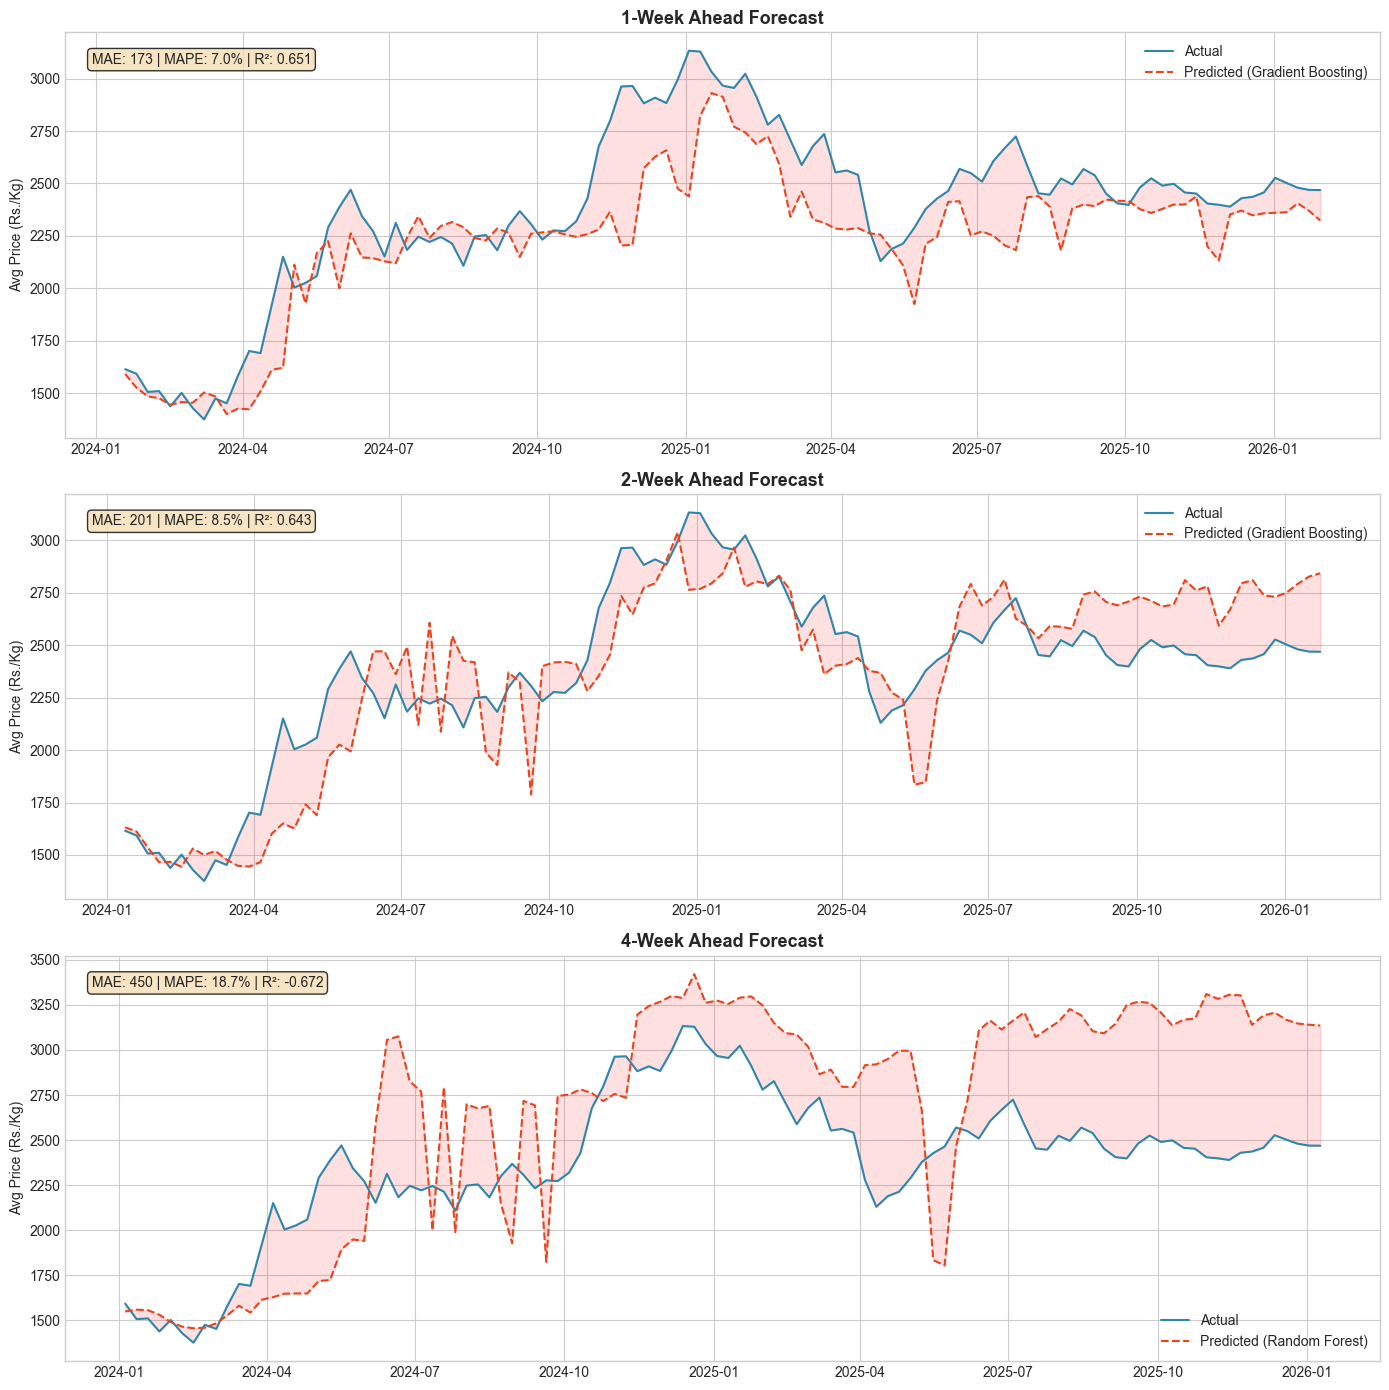

In [9]:
# Plot actual vs predicted for each horizon (best enriched model)
fig, axes = plt.subplots(3, 1, figsize=(14, 14))

for ax, horizon, hlabel in zip(axes, horizons, horizon_labels.values()):
    # Find best enriched model for this horizon
    subset = results_df[(results_df['Horizon']==hlabel) & (results_df['Features']=='Enriched')]
    best_model_name = subset.loc[subset['MAE'].idxmin(), 'Model']
    key = f'{hlabel}_Enriched_{best_model_name}'
    
    actual = all_preds[key]['actual']
    pred = all_preds[key]['pred']
    weeks = pd.to_datetime(all_preds[key]['weeks'])
    
    ax.plot(weeks, actual, label='Actual', color='#2E86AB', linewidth=1.5)
    ax.plot(weeks, pred, label=f'Predicted ({best_model_name})', color='#E8451E', 
            linewidth=1.5, linestyle='--')
    ax.fill_between(weeks, actual, pred, alpha=0.12, color='red')
    ax.set_title(f'{hlabel} Ahead Forecast', fontsize=13, fontweight='bold')
    ax.set_ylabel('Avg Price (Rs./Kg)')
    ax.legend()
    
    mae = mean_absolute_error(actual, pred)
    mape = mean_absolute_percentage_error(actual, pred) * 100
    r2 = r2_score(actual, pred)
    ax.text(0.02, 0.95, f'MAE: {mae:.0f} | MAPE: {mape:.1f}% | R²: {r2:.3f}',
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

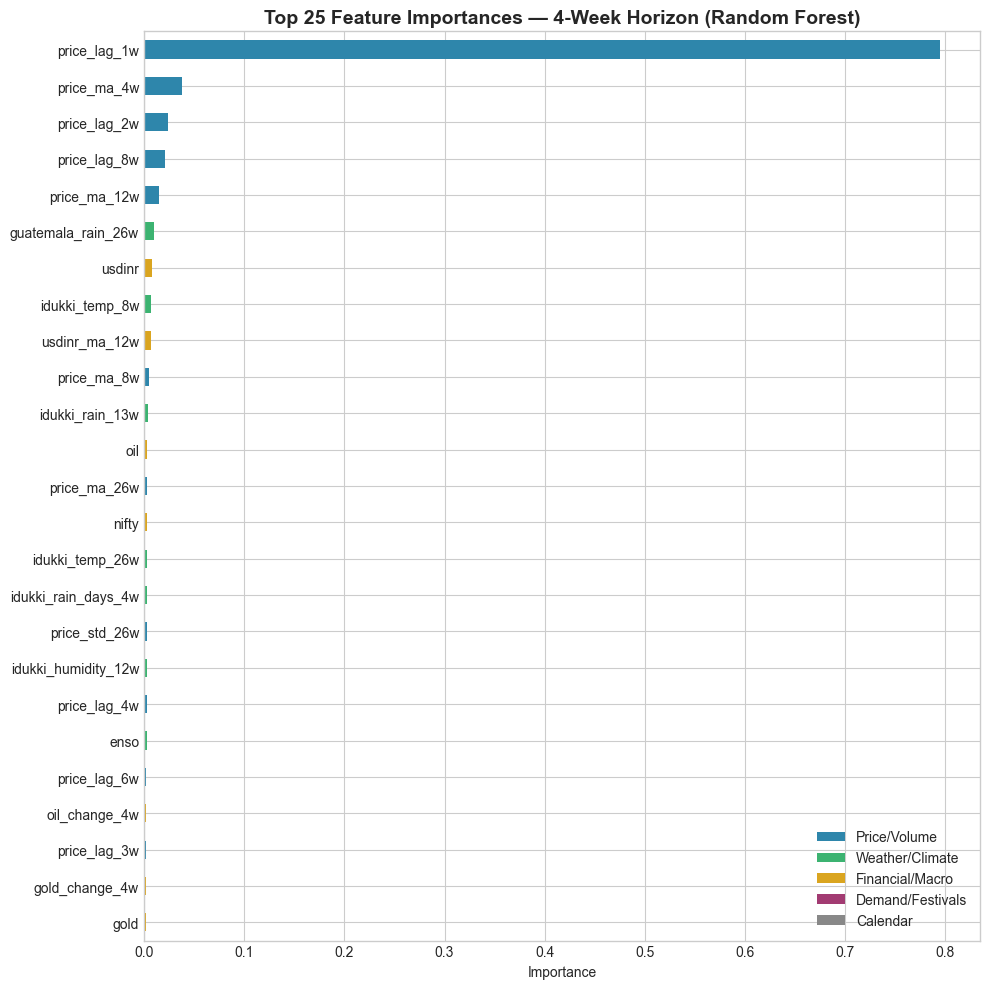

In [10]:
# Feature importance for 4-week horizon (where external data matters most)
key_4w_enriched = None
subset_4w = results_df[(results_df['Horizon']=='4-Week') & (results_df['Features']=='Enriched')]
best_4w_model_name = subset_4w.loc[subset_4w['MAE'].idxmin(), 'Model']
key_4w = f'4-Week_Enriched_{best_4w_model_name}'

model_4w = all_preds[key_4w]['model']
feat_names_4w = all_preds[key_4w]['features']

if hasattr(model_4w, 'feature_importances_'):
    importances = model_4w.feature_importances_
elif hasattr(model_4w, 'coef_'):
    importances = np.abs(model_4w.coef_)
else:
    importances = np.zeros(len(feat_names_4w))

feat_imp = pd.Series(importances, index=feat_names_4w).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 10))

# Color by category
colors = []
for f in feat_imp.tail(25).index:
    if any(f.startswith(p) for p in ['price_', 'sold_', 'arrived_', 'sell_', 'max_avg']):
        colors.append('#2E86AB')   # price/volume
    elif any(x in f for x in ['rain', 'temp', 'humid', 'enso', 'idukki', 'guatemala']):
        colors.append('#3CB371')   # weather/climate
    elif any(x in f for x in ['usdinr', 'oil', 'gold', 'nifty']):
        colors.append('#DAA520')   # financial
    elif any(x in f for x in ['wedding', 'harvest', 'eid', 'diwali', 'onam', 'xmas', 'peak']):
        colors.append('#A23B72')   # demand
    else:
        colors.append('#888888')   # calendar

feat_imp.tail(25).plot(kind='barh', ax=ax, color=colors)
ax.set_title(f'Top 25 Feature Importances — 4-Week Horizon ({best_4w_model_name})',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Importance')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2E86AB', label='Price/Volume'),
                   Patch(facecolor='#3CB371', label='Weather/Climate'),
                   Patch(facecolor='#DAA520', label='Financial/Macro'),
                   Patch(facecolor='#A23B72', label='Demand/Festivals'),
                   Patch(facecolor='#888888', label='Calendar')]
ax.legend(handles=legend_elements, loc='lower right')
plt.tight_layout()
plt.show()

In [11]:
# Count features by category in top 25
top25 = feat_imp.tail(25)
categories = {'Price/Volume': 0, 'Weather/Climate': 0, 'Financial/Macro': 0, 'Demand/Festivals': 0, 'Calendar': 0}
for f in top25.index:
    if any(f.startswith(p) for p in ['price_', 'sold_', 'arrived_', 'sell_', 'max_avg']):
        categories['Price/Volume'] += 1
    elif any(x in f for x in ['rain', 'temp', 'humid', 'enso', 'idukki', 'guatemala']):
        categories['Weather/Climate'] += 1
    elif any(x in f for x in ['usdinr', 'oil', 'gold', 'nifty']):
        categories['Financial/Macro'] += 1
    elif any(x in f for x in ['wedding', 'harvest', 'eid', 'diwali', 'onam', 'xmas', 'peak']):
        categories['Demand/Festivals'] += 1
    else:
        categories['Calendar'] += 1

print('Top 25 Features by Category (4-Week Horizon):')
for cat, count in sorted(categories.items(), key=lambda x: -x[1]):
    print(f'  {cat}: {count} features')
    
# Show importance share by category
cat_importance = {'Price/Volume': 0, 'Weather/Climate': 0, 'Financial/Macro': 0, 'Demand/Festivals': 0, 'Calendar': 0}
for f, imp in zip(feat_imp.index, feat_imp.values):
    if any(f.startswith(p) for p in ['price_', 'sold_', 'arrived_', 'sell_', 'max_avg']):
        cat_importance['Price/Volume'] += imp
    elif any(x in f for x in ['rain', 'temp', 'humid', 'enso', 'idukki', 'guatemala']):
        cat_importance['Weather/Climate'] += imp
    elif any(x in f for x in ['usdinr', 'oil', 'gold', 'nifty']):
        cat_importance['Financial/Macro'] += imp
    elif any(x in f for x in ['wedding', 'harvest', 'eid', 'diwali', 'onam', 'xmas', 'peak']):
        cat_importance['Demand/Festivals'] += imp
    else:
        cat_importance['Calendar'] += imp

total = sum(cat_importance.values())
print(f'\nTotal Importance Share:')
for cat, imp in sorted(cat_importance.items(), key=lambda x: -x[1]):
    print(f'  {cat}: {imp/total*100:.1f}%')

Top 25 Features by Category (4-Week Horizon):
  Price/Volume: 11 features
  Weather/Climate: 7 features
  Financial/Macro: 7 features
  Demand/Festivals: 0 features
  Calendar: 0 features

Total Importance Share:
  Price/Volume: 92.4%
  Weather/Climate: 4.3%
  Financial/Macro: 3.1%
  Calendar: 0.1%
  Demand/Festivals: 0.0%


## 8. Directional Accuracy

For traders, getting the **direction** right matters as much as the level.  
Did the model correctly predict whether price would go UP or DOWN?

In [12]:
# Directional accuracy
print(f'{"Horizon":<12} {"Features":<12} {"Model":<22} {"Direction Accuracy":>20}')
print('-' * 70)

for key, data in all_preds.items():
    parts = key.split('_')
    horizon = parts[0]
    feat_type = parts[1]
    model_name = '_'.join(parts[2:])
    
    actual = data['actual']
    pred = data['pred']
    weeks = pd.to_datetime(data['weeks'])
    
    # Get the current price at prediction time
    # Direction: did both actual and predicted move in the same direction from current?
    si = int(len(feat) * 0.8)
    valid = feat.dropna(subset=['target_1w']).reset_index(drop=True)
    current_prices = valid['AvgPrice'].iloc[int(len(valid)*0.8):int(len(valid)*0.8)+len(actual)].values
    
    if len(current_prices) == len(actual):
        actual_dir = np.sign(actual - current_prices)
        pred_dir = np.sign(pred - current_prices)
        dir_accuracy = (actual_dir == pred_dir).mean() * 100
        print(f'{horizon:<12} {feat_type:<12} {model_name:<22} {dir_accuracy:>19.1f}%')

Horizon      Features     Model                    Direction Accuracy
----------------------------------------------------------------------
1-Week       Baseline     Ridge                                 57.9%
1-Week       Baseline     Random Forest                         51.4%
1-Week       Baseline     Gradient Boosting                     51.4%
1-Week       Enriched     Ridge                                 57.0%
1-Week       Enriched     Random Forest                         49.5%
1-Week       Enriched     Gradient Boosting                     55.1%
2-Week       Baseline     Ridge                                 59.8%
2-Week       Baseline     Random Forest                         45.8%
2-Week       Baseline     Gradient Boosting                     47.7%
2-Week       Enriched     Ridge                                 50.5%
2-Week       Enriched     Random Forest                         43.9%
2-Week       Enriched     Gradient Boosting                     44.9%
4-Week       Baseli

## 9. 4-Week Forward Forecast

In [13]:
# Retrain best model on ALL data and forecast
target_4w = 'target_4w'
valid_all = feat.dropna(subset=[target_4w]).reset_index(drop=True)

best_4w_feats = all_preds[key_4w]['features']
X_all = valid_all[best_4w_feats].fillna(0)
y_all = valid_all[target_4w]

# Retrain
if best_4w_model_name == 'Ridge':
    final_model = Ridge(alpha=10.0)
elif best_4w_model_name == 'Random Forest':
    final_model = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_leaf=5, random_state=42, n_jobs=-1)
else:
    final_model = GradientBoostingRegressor(n_estimators=300, max_depth=5, learning_rate=0.03, subsample=0.8,
                                            min_samples_leaf=5, random_state=42)

final_model.fit(X_all, y_all)

# Predict using latest available features
last_row = feat.iloc[-1:][best_4w_feats].fillna(0)
forecast_4w = final_model.predict(last_row)[0]
last_week = feat['Week'].iloc[-1]
forecast_date = last_week + timedelta(weeks=4)

# Also do 1-week and 2-week with their best models
forecasts = {}
for horizon, hlabel in horizon_labels.items():
    sub = results_df[(results_df['Horizon']==hlabel) & (results_df['Features']=='Enriched')]
    bm_name = sub.loc[sub['MAE'].idxmin(), 'Model']
    bm_key = f'{hlabel}_Enriched_{bm_name}'
    bm_feats = all_preds[bm_key]['features']
    
    target_col = f'target_{horizon}w'
    valid_h = feat.dropna(subset=[target_col]).reset_index(drop=True)
    X_h = valid_h[bm_feats].fillna(0)
    y_h = valid_h[target_col]
    
    if bm_name == 'Ridge':
        m = Ridge(alpha=10.0)
    elif bm_name == 'Random Forest':
        m = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_leaf=5, random_state=42, n_jobs=-1)
    else:
        m = GradientBoostingRegressor(n_estimators=300, max_depth=5, learning_rate=0.03, subsample=0.8,
                                      min_samples_leaf=5, random_state=42)
    m.fit(X_h, y_h)
    
    last_features = feat.iloc[-1:][bm_feats].fillna(0)
    pred = m.predict(last_features)[0]
    target_date = last_week + timedelta(weeks=horizon)
    
    forecasts[hlabel] = {
        'target_date': target_date,
        'predicted_price': pred,
        'model': bm_name
    }

# Display
current_price = feat['AvgPrice'].iloc[-1]
print(f'Current Price (week of {last_week.date()}): Rs. {current_price:.2f}/Kg')
print(f'\n{"Horizon":<12} {"Target Week":<16} {"Predicted Price":>16} {"Change":>10} {"Model":<20}')
print('-' * 78)
for hlabel, fcast in forecasts.items():
    change = fcast['predicted_price'] - current_price
    pct = change / current_price * 100
    sign = '+' if change >= 0 else ''
    print(f'{hlabel:<12} {fcast["target_date"].date()!s:<16} '
          f'Rs. {fcast["predicted_price"]:>8.2f}    {sign}{change:>6.1f} ({sign}{pct:.1f}%)  {fcast["model"]}')

Current Price (week of 2026-02-06): Rs. 2468.64/Kg

Horizon      Target Week       Predicted Price     Change Model               
------------------------------------------------------------------------------
1-Week       2026-02-13       Rs.  2445.50     -23.1 (-0.9%)  Gradient Boosting
2-Week       2026-02-20       Rs.  2490.24    +  21.6 (+0.9%)  Gradient Boosting
4-Week       2026-03-06       Rs.  2577.42    + 108.8 (+4.4%)  Random Forest


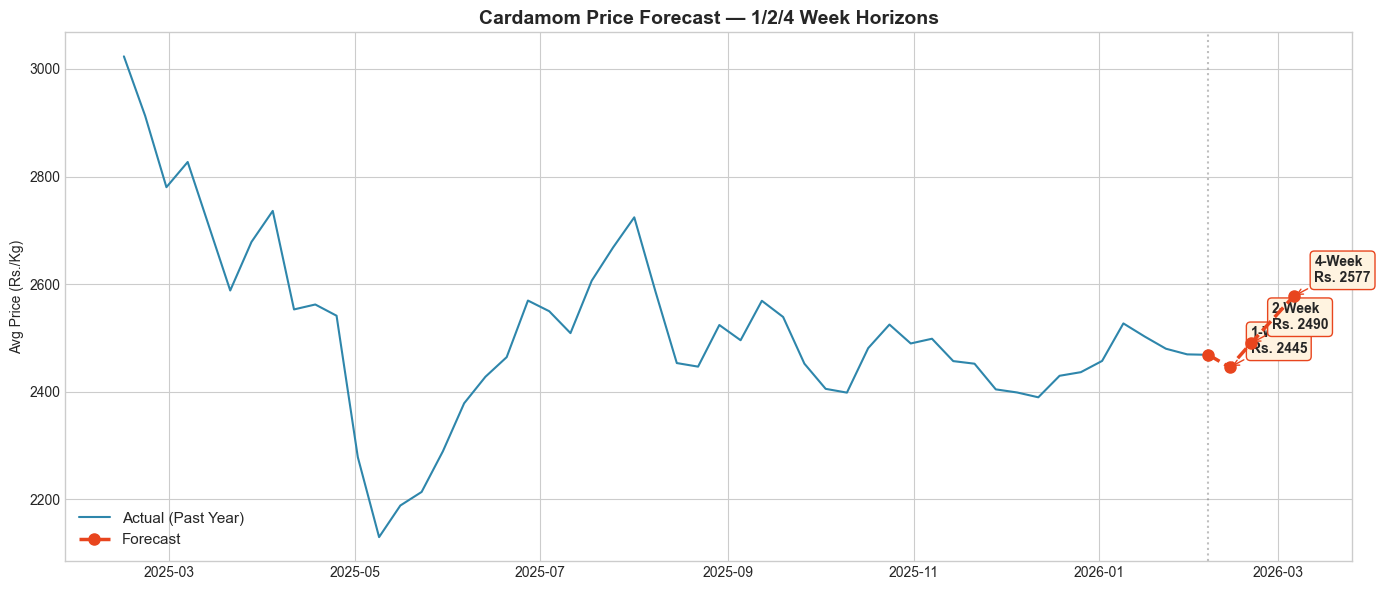

In [14]:
# Visualize forecast
fig, ax = plt.subplots(figsize=(14, 6))

# Recent history
recent = feat.tail(52)  # last year
ax.plot(recent['Week'], recent['AvgPrice'], label='Actual (Past Year)', color='#2E86AB', linewidth=1.5)

# Forecast points
forecast_dates = [f['target_date'] for f in forecasts.values()]
forecast_prices = [f['predicted_price'] for f in forecasts.values()]

# Connect last actual to first forecast
ax.plot([recent['Week'].iloc[-1]] + forecast_dates,
        [recent['AvgPrice'].iloc[-1]] + forecast_prices,
        label='Forecast', color='#E8451E', linewidth=2.5, linestyle='--',
        marker='o', markersize=8, zorder=5)

# Annotate
for hlabel, fcast in forecasts.items():
    ax.annotate(f'{hlabel}\nRs. {fcast["predicted_price"]:.0f}',
                (fcast['target_date'], fcast['predicted_price']),
                textcoords='offset points', xytext=(15, 10),
                fontsize=10, fontweight='bold',
                arrowprops=dict(arrowstyle='->', color='#E8451E'),
                bbox=dict(boxstyle='round,pad=0.3', facecolor='#FFF3E0', edgecolor='#E8451E'))

ax.axvline(recent['Week'].iloc[-1], color='gray', linestyle=':', alpha=0.5)
ax.set_title('Cardamom Price Forecast — 1/2/4 Week Horizons', fontsize=14, fontweight='bold')
ax.set_ylabel('Avg Price (Rs./Kg)')
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

## 10. Summary

### Approach
- **Weekly resampling** to smooth noise and align with decision-making cadence
- **Three horizons**: 1-week, 2-week, 4-week ahead predictions
- **Direct forecasting**: separate models per horizon (not iterative multi-step)
- **Baseline vs Enriched** comparison at each horizon

### Key Insights
- At longer horizons, lag prices lose dominance and **external features gain importance**
- Feature importance reveals which real-world signals drive prices at the 4-week horizon
- Directional accuracy shows whether the model can predict price direction (up/down)

### Previous Model (Backup)
The next-day model is saved as `Cardamom_Price_Forecast_Enriched_NextDay_Backup.ipynb`

### Further Improvements
- Add Guatemala export volume data (UN Comtrade API key needed)
- Add Google Trends "cardamom" as a demand proxy
- Try LSTM/Transformer for sequence modeling
- Walk-forward cross-validation for more robust evaluation
- Prediction intervals / uncertainty quantification